In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
file_path = 'WaterQuality/imputed_data.csv'
df = pd.read_csv(file_path)
import warnings

warnings.filterwarnings('ignore')
sns.set_style()

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ph,3276.0,7.080140,1.471573,0.000000,6.277673,7.062162,7.870050,14.000000
Hardness,3276.0,196.369496,32.879761,47.432000,176.850538,196.967627,216.667456,323.124000
Solids,3276.0,22014.092526,8768.570828,320.942611,15666.690297,20927.833607,27332.762127,61227.196008
Chloramines,3276.0,7.122277,1.583085,0.352000,6.127421,7.130299,8.114887,13.127000
Sulfate,3276.0,333.785030,36.387826,129.000000,316.140728,334.045574,350.592000,481.030642
Conductivity,3276.0,426.205111,80.824064,181.483754,365.734414,421.884968,481.792304,753.342620
Organic_carbon,3276.0,14.284970,3.308162,2.200000,12.065801,14.218338,16.557652,28.300000
Trihalomethanes,3276.0,66.395409,15.769922,0.738000,56.647656,66.426547,76.666609,124.000000
Turbidity,3276.0,3.966786,0.780382,1.450000,3.439711,3.955028,4.500320,6.739000
Potability,3276.0,0.390110,0.487849,0.000000,0.000000,0.000000,1.000000,1.000000


- PH değişkeninde gözlenen aykırılık veri setinin doğası gereği anlamlıdır asit ve bazlar 0 ile 14 arasında 7 sınır değeri olmak üzere derecelere ayrılırlar

In [26]:
from sklearn.ensemble import IsolationForest
import pandas as pd
import numpy as np


isolation_forest = IsolationForest(contamination=0.05, random_state=42) 


outliers = isolation_forest.fit_predict(df)


outliers = pd.Series(outliers, index=df.index)


df_without_outliers = df[outliers == 1] 


print(f"Outliers removed. New number of rows: {df_without_outliers.shape[0]}")

Outliers removed. New number of rows: 3112


In [28]:
df_without_outliers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               3276 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          3276 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3276 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   float64
dtypes: float64(10)
memory usage: 256.1 KB


In [33]:
from scipy.stats import boxcox
import pandas as pd


df_transformed = df_without_outliers.copy() 
df_transformed['Solids'], _ = boxcox(df_transformed['Solids'] + 1)  




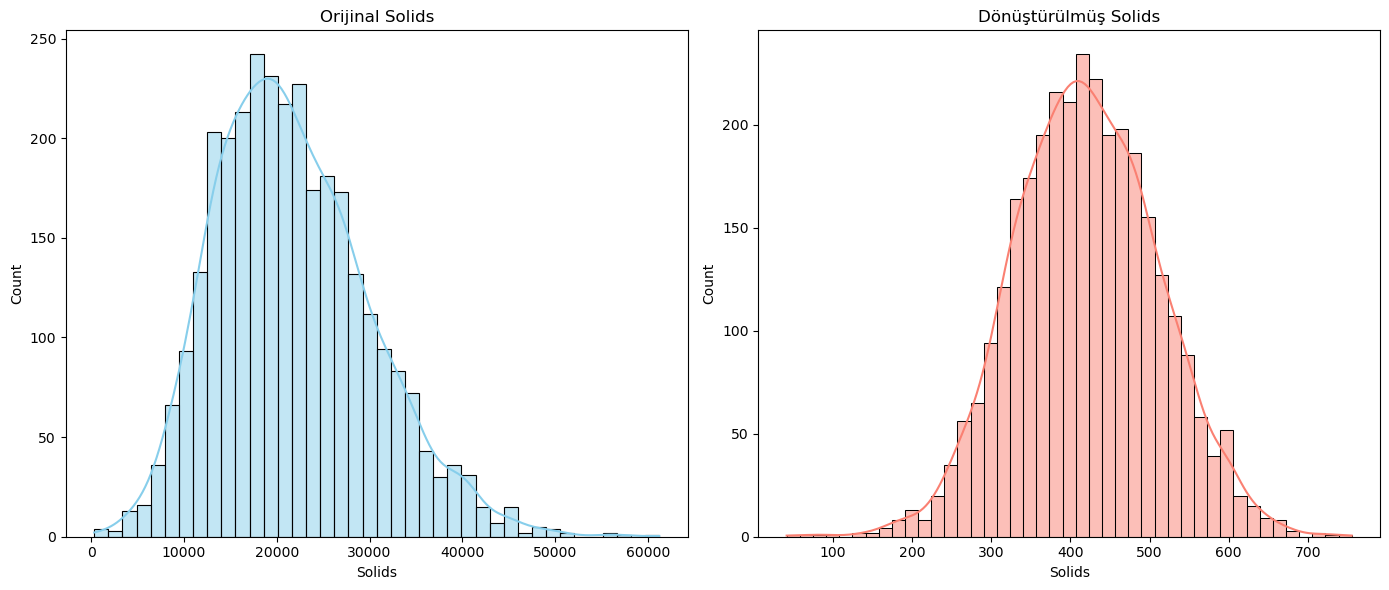

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, ax = plt.subplots(1, 2, figsize=(14, 6))


sns.histplot(df_without_outliers['Solids'], kde=True, ax=ax[0], color='skyblue')
ax[0].set_title('Orijinal Solids')


sns.histplot(df_transformed['Solids'], kde=True, ax=ax[1], color='salmon')
ax[1].set_title('Dönüştürülmüş Solids')

plt.tight_layout()
plt.show()


- isolation forest kullanarak outlierların bir kısmını bastırdık ve hafif sağa çarpık olan solid değişkenin box-cox yöntemi ile çarpıklığını gidermeye çalıstık 

Bundan sonra model kurarak orijinal yani müdahele edilmemiş veri seti ve müdahele edilmiş veri setinin performanslarını karşılaştıracağız

In [45]:
df['Potability'].value_counts()

Potability
0.0    1998
1.0    1278
Name: count, dtype: int64

In [47]:
df_transformed['Potability'].value_counts()

Potability
0.0    1943
1.0    1169
Name: count, dtype: int64

- Hedef Değişkenimiz Potability için class imbalance sorunu yoktur

## Model Süreci

#### Random Forest

In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder



y = df['Potability']
X = df.drop(columns=['Potability'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)


y_pred = model_rf.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Model Accuracy: {accuracy}")


feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model_rf.feature_importances_})
print(feature_importance.sort_values(by='Importance', ascending=False))

Random Forest Model Accuracy: 0.6753048780487805
           Feature  Importance
4          Sulfate    0.137764
0               ph    0.132399
1         Hardness    0.118616
3      Chloramines    0.111524
2           Solids    0.110415
6   Organic_carbon    0.099395
5     Conductivity    0.098987
7  Trihalomethanes    0.096217
8        Turbidity    0.094682


In [61]:

y_train_pred = model_rf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Train Accuracy: {train_accuracy}")


test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy}")


train_error = 1 - train_accuracy
print(f"Train Error: {train_error}")


test_error = 1 - test_accuracy
print(f"Test Error: {test_error}")


Train Accuracy: 1.0
Test Accuracy: 0.6753048780487805
Train Error: 0.0
Test Error: 0.3246951219512195


Random Forest - Eğitim Verisi Doğruluğu: 1.0
Random Forest - Test Verisi Doğruluğu: 0.6753048780487805


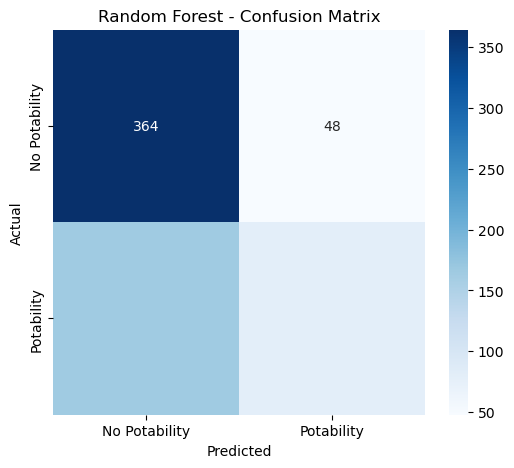

Random Forest - Classification Report
              precision    recall  f1-score   support

         0.0       0.69      0.88      0.77       412
         1.0       0.62      0.32      0.43       244

    accuracy                           0.68       656
   macro avg       0.66      0.60      0.60       656
weighted avg       0.66      0.68      0.64       656



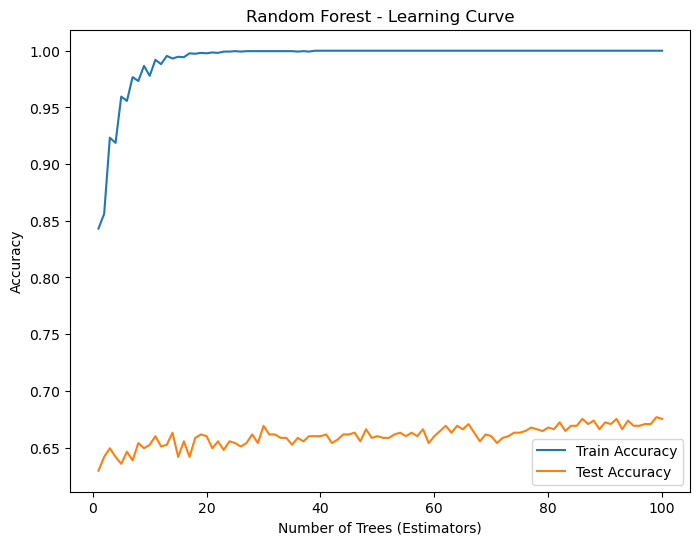

In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


train_accuracy_rf = model_rf.score(X_train, y_train)
test_accuracy_rf = model_rf.score(X_test, y_test)

print(f"Random Forest - Eğitim Verisi Doğruluğu: {train_accuracy_rf}")
print(f"Random Forest - Test Verisi Doğruluğu: {test_accuracy_rf}")


y_pred_rf = model_rf.predict(X_test)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", xticklabels=['No Potability', 'Potability'], yticklabels=['No Potability', 'Potability'])
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


print("Random Forest - Classification Report")
print(classification_report(y_test, y_pred_rf))


train_scores, test_scores = [], []
for i in range(1, 101):  
    model_rf = RandomForestClassifier(n_estimators=i, random_state=42)
    model_rf.fit(X_train, y_train)
    train_scores.append(model_rf.score(X_train, y_train))
    test_scores.append(model_rf.score(X_test, y_test))

plt.figure(figsize=(8, 6))
plt.plot(range(1, 101), train_scores, label="Train Accuracy")
plt.plot(range(1, 101), test_scores, label="Test Accuracy")
plt.title("Random Forest - Learning Curve")
plt.xlabel("Number of Trees (Estimators)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### Model Tuning

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
En İyi Parametreler: {'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Test Doğruluğu: 0.6737804878048781


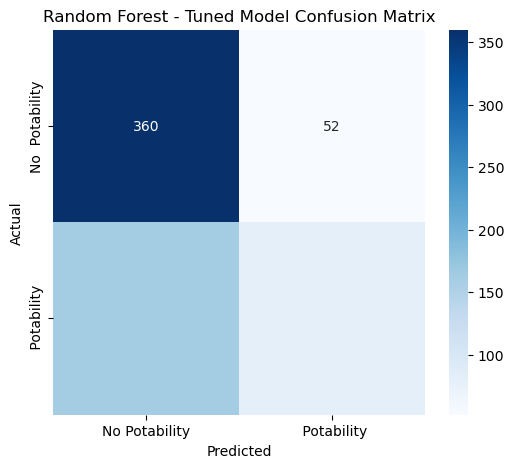

Random Forest - Tuned Model Classification Report
              precision    recall  f1-score   support

         0.0       0.69      0.87      0.77       412
         1.0       0.61      0.34      0.43       244

    accuracy                           0.67       656
   macro avg       0.65      0.60      0.60       656
weighted avg       0.66      0.67      0.65       656



In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


param_grid = {
    'n_estimators': [50, 100, 150, 200],  # Ağaç sayısı
    'max_depth': [None, 10, 20, 30],  # Ağaç derinliği
    'min_samples_split': [2, 5, 10],  # Bölme için min örnek sayısı
    'min_samples_leaf': [1, 2, 4],  # Yaprak düğümünde min örnek sayısı
    'max_features': ['auto', 'sqrt', 'log2']  # Kullanılacak özellik sayısı
}


rf_model = RandomForestClassifier(random_state=42)


grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')


grid_search.fit(X_train, y_train)


print(f"En İyi Parametreler: {grid_search.best_params_}")


best_rf_model = grid_search.best_estimator_


test_accuracy = best_rf_model.score(X_test, y_test)
print(f"Test Doğruluğu: {test_accuracy}")


y_pred_rf_best = best_rf_model.predict(X_test)
conf_matrix_rf_best = confusion_matrix(y_test, y_pred_rf_best)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_rf_best, annot=True, fmt="d", cmap="Blues", xticklabels=['No Potability', ' Potability'], yticklabels=['No  Potability', ' Potability'])
plt.title("Random Forest - Tuned Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


print("Random Forest - Tuned Model Classification Report")
print(classification_report(y_test, y_pred_rf_best))

In [69]:

train_accuracy = best_rf_model.score(X_train, y_train)
print(f"Train Doğruluğu: {train_accuracy}")


test_accuracy = best_rf_model.score(X_test, y_test)
print(f"Test Doğruluğu: {test_accuracy}")


train_error = 1 - train_accuracy
test_error = 1 - test_accuracy

print(f"Train Hata Oranı: {train_error}")
print(f"Test Hata Oranı: {test_error}")


Train Doğruluğu: 0.999618320610687
Test Doğruluğu: 0.6737804878048781
Train Hata Oranı: 0.0003816793893129944
Test Hata Oranı: 0.3262195121951219


- overfit'den hala kurtulamadık hiperparametre analizi yaparak tune etmeye devam edeceğiz

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
En İyi Tunelenmiş Parametreler (Yeni): {'class_weight': None, 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}
Train Doğruluğu (Yeni Tuned): 0.9564885496183206
Test Doğruluğu (Yeni Tuned): 0.6875
Train Hata Oranı (Yeni Tuned): 0.04351145038167936
Test Hata Oranı (Yeni Tuned): 0.3125


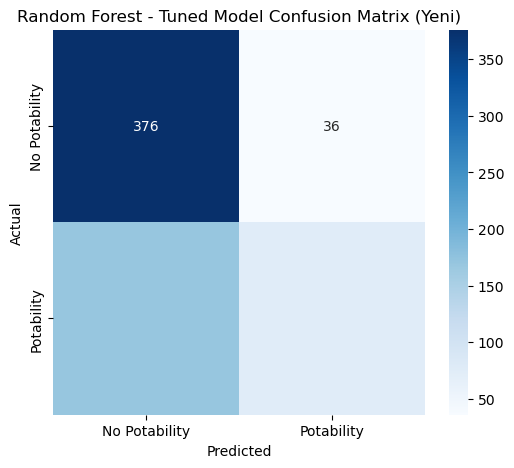

Random Forest - Tuned Model Classification Report (Yeni)
              precision    recall  f1-score   support

         0.0       0.69      0.91      0.79       412
         1.0       0.68      0.31      0.42       244

    accuracy                           0.69       656
   macro avg       0.68      0.61      0.60       656
weighted avg       0.68      0.69      0.65       656



In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


param_grid_tuned_2 = {
    'n_estimators': [50, 100, 150],  # Ağaç sayısını sınırlayalım
    'max_depth': [10, 15, 20],        # Daha düşük derinlikler seçelim
    'min_samples_split': [10, 15, 20],  # Bölme için daha fazla örnek sayısı
    'min_samples_leaf': [4, 6, 8],     # Yaprak düğümünde daha fazla örnek
    'max_features': ['auto', 'sqrt'],  # Özellik sayısını sınırlayalım
    'class_weight': [None, 'balanced']  # Dengesiz sınıflar için balanced
}


rf_model_tuned_2 = RandomForestClassifier(random_state=42)


grid_search_tuned_2 = GridSearchCV(estimator=rf_model_tuned_2, param_grid=param_grid_tuned_2, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')


grid_search_tuned_2.fit(X_train, y_train)


print(f"En İyi Tunelenmiş Parametreler (Yeni): {grid_search_tuned_2.best_params_}")


best_rf_model_tuned_2 = grid_search_tuned_2.best_estimator_
y_pred_rf_tuned_2 = best_rf_model_tuned_2.predict(X_test)


train_accuracy_tuned_2 = best_rf_model_tuned_2.score(X_train, y_train)
test_accuracy_tuned_2 = best_rf_model_tuned_2.score(X_test, y_test)


train_error_tuned_2 = 1 - train_accuracy_tuned_2
test_error_tuned_2 = 1 - test_accuracy_tuned_2

print(f"Train Doğruluğu (Yeni Tuned): {train_accuracy_tuned_2}")
print(f"Test Doğruluğu (Yeni Tuned): {test_accuracy_tuned_2}")
print(f"Train Hata Oranı (Yeni Tuned): {train_error_tuned_2}")
print(f"Test Hata Oranı (Yeni Tuned): {test_error_tuned_2}")


conf_matrix_rf_tuned_2 = confusion_matrix(y_test, y_pred_rf_tuned_2)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_rf_tuned_2, annot=True, fmt="d", cmap="Blues", xticklabels=['No Potability', 'Potability'], yticklabels=['No Potability', 'Potability'])
plt.title("Random Forest - Tuned Model Confusion Matrix (Yeni)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Random Forest - Tuned Model Classification Report (Yeni)")
print(classification_report(y_test, y_pred_rf_tuned_2))


### Sonuç olarak test ve train hatası test ve train doğruluk oranındaki fark yüksek bu overfite işaret ediyor şimdi outlier ve çarpıklığı giderdiğimiz veri ile aynı modeli kuracağız

In [79]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder



y = df_transformed['Potability']
X = df_transformed.drop(columns=['Potability'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)


y_pred = model_rf.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Model Accuracy: {accuracy}")


feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model_rf.feature_importances_})
print(feature_importance.sort_values(by='Importance', ascending=False))

Random Forest Model Accuracy: 0.7030497592295345
           Feature  Importance
0               ph    0.130034
4          Sulfate    0.127186
1         Hardness    0.118335
3      Chloramines    0.115821
2           Solids    0.115063
6   Organic_carbon    0.100100
5     Conductivity    0.099230
7  Trihalomethanes    0.097679
8        Turbidity    0.096551


In [81]:
y_train_pred = model_rf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Train Accuracy: {train_accuracy}")


test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy}")


train_error = 1 - train_accuracy
print(f"Train Error: {train_error}")


test_error = 1 - test_accuracy
print(f"Test Error: {test_error}")

Train Accuracy: 1.0
Test Accuracy: 0.7030497592295345
Train Error: 0.0
Test Error: 0.2969502407704655


Random Forest algoritması outlier ve çarpıklık ve dağılımdan çok etkilenen algoritmalar arasında değildir ama buna rağmen test hatasında biraz azalma gözlemledik

#### Model Tuning

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
En İyi Tunelenmiş Parametreler (Yeni): {'class_weight': None, 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 20, 'n_estimators': 50}
Train Doğruluğu (Yeni Tuned): 0.8770590598633989
Test Doğruluğu (Yeni Tuned): 0.6902086677367576
Train Hata Oranı (Yeni Tuned): 0.12294094013660106
Test Hata Oranı (Yeni Tuned): 0.3097913322632424


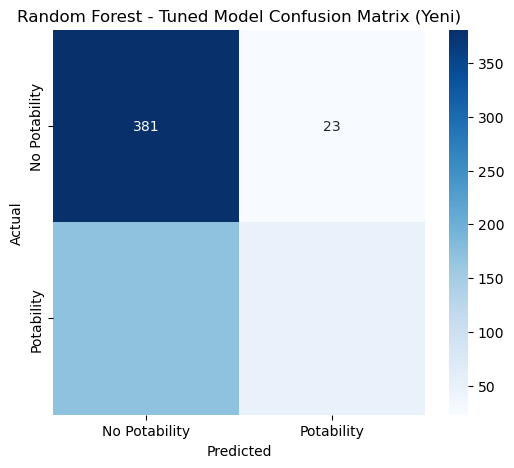

Random Forest - Tuned Model Classification Report (Yeni)
              precision    recall  f1-score   support

         0.0       0.69      0.94      0.80       404
         1.0       0.68      0.22      0.34       219

    accuracy                           0.69       623
   macro avg       0.69      0.58      0.57       623
weighted avg       0.69      0.69      0.64       623



In [88]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


param_grid_tuned_2 = {
    'n_estimators': [50, 100, 150],  # Ağaç sayısını sınırlayalım
    'max_depth': [10, 15, 20],        # Daha düşük derinlikler seçelim
    'min_samples_split': [10, 15, 20],  # Bölme için daha fazla örnek sayısı
    'min_samples_leaf': [4, 6, 8],     # Yaprak düğümünde daha fazla örnek
    'max_features': ['auto', 'sqrt'],  # Özellik sayısını sınırlayalım
    'class_weight': [None, 'balanced']  # Dengesiz sınıflar için balanced
}


rf_model_tuned_2 = RandomForestClassifier(random_state=42)


grid_search_tuned_2 = GridSearchCV(estimator=rf_model_tuned_2, param_grid=param_grid_tuned_2, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')


grid_search_tuned_2.fit(X_train, y_train)


print(f"En İyi Tunelenmiş Parametreler (Yeni): {grid_search_tuned_2.best_params_}")


best_rf_model_tuned_2 = grid_search_tuned_2.best_estimator_
y_pred_rf_tuned_2 = best_rf_model_tuned_2.predict(X_test)


train_accuracy_tuned_2 = best_rf_model_tuned_2.score(X_train, y_train)
test_accuracy_tuned_2 = best_rf_model_tuned_2.score(X_test, y_test)


train_error_tuned_2 = 1 - train_accuracy_tuned_2
test_error_tuned_2 = 1 - test_accuracy_tuned_2

print(f"Train Doğruluğu (Yeni Tuned): {train_accuracy_tuned_2}")
print(f"Test Doğruluğu (Yeni Tuned): {test_accuracy_tuned_2}")
print(f"Train Hata Oranı (Yeni Tuned): {train_error_tuned_2}")
print(f"Test Hata Oranı (Yeni Tuned): {test_error_tuned_2}")


conf_matrix_rf_tuned_2 = confusion_matrix(y_test, y_pred_rf_tuned_2)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_rf_tuned_2, annot=True, fmt="d", cmap="Blues", xticklabels=['No Potability', 'Potability'], yticklabels=['No Potability', 'Potability'])
plt.title("Random Forest - Tuned Model Confusion Matrix (Yeni)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Random Forest - Tuned Model Classification Report (Yeni)")
print(classification_report(y_test, y_pred_rf_tuned_2))


### XBOOST 

Test Doğruluğu (XGBoost): 0.6387195121951219
Train Doğruluğu (XGBoost): 0.9980916030534351
Test Hata Oranı (XGBoost): 0.3612804878048781
Train Hata Oranı (XGBoost): 0.001908396946564861


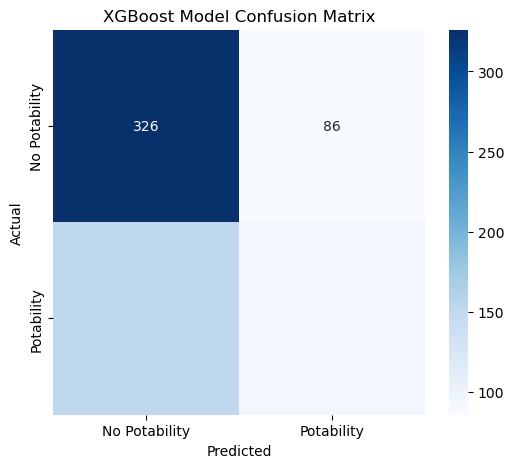

XGBoost Model Classification Report
              precision    recall  f1-score   support

         0.0       0.68      0.79      0.73       412
         1.0       0.52      0.38      0.44       244

    accuracy                           0.64       656
   macro avg       0.60      0.59      0.59       656
weighted avg       0.62      0.64      0.62       656



In [93]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


X = df.drop(columns=['Potability'])
y = df['Potability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model_xgb = xgb.XGBClassifier(random_state=42, use_label_encoder=False)


model_xgb.fit(X_train, y_train)


y_pred_xgb = model_xgb.predict(X_test)


test_accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Test Doğruluğu (XGBoost): {test_accuracy_xgb}")


train_accuracy_xgb = model_xgb.score(X_train, y_train)
train_error_xgb = 1 - train_accuracy_xgb
test_error_xgb = 1 - test_accuracy_xgb

print(f"Train Doğruluğu (XGBoost): {train_accuracy_xgb}")
print(f"Test Hata Oranı (XGBoost): {test_error_xgb}")
print(f"Train Hata Oranı (XGBoost): {train_error_xgb}")


conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=['No Potability', 'Potability'], yticklabels=['No Potability', 'Potability'])
plt.title("XGBoost Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


print("XGBoost Model Classification Report")
print(classification_report(y_test, y_pred_xgb))


- Aynı modeli bir de işlem yapılmıs veri setinde deniyoruz

Test Doğruluğu (XGBoost): 0.6725521669341894
Train Doğruluğu (XGBoost): 0.9991964644435516
Test Hata Oranı (XGBoost): 0.3274478330658106
Train Hata Oranı (XGBoost): 0.0008035355564484092


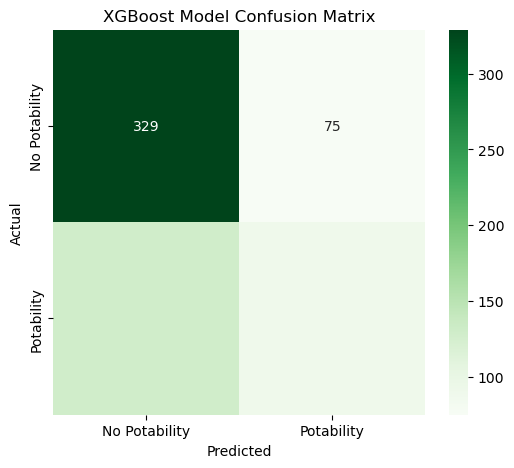

XGBoost Model Classification Report
              precision    recall  f1-score   support

         0.0       0.72      0.81      0.76       404
         1.0       0.55      0.41      0.47       219

    accuracy                           0.67       623
   macro avg       0.63      0.61      0.62       623
weighted avg       0.66      0.67      0.66       623



In [99]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


X = df_transformed.drop(columns=['Potability'])
y = df_transformed['Potability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model_xgb = xgb.XGBClassifier(random_state=42, use_label_encoder=False)


model_xgb.fit(X_train, y_train)


y_pred_xgb = model_xgb.predict(X_test)


test_accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Test Doğruluğu (XGBoost): {test_accuracy_xgb}")


train_accuracy_xgb = model_xgb.score(X_train, y_train)
train_error_xgb = 1 - train_accuracy_xgb
test_error_xgb = 1 - test_accuracy_xgb

print(f"Train Doğruluğu (XGBoost): {train_accuracy_xgb}")
print(f"Test Hata Oranı (XGBoost): {test_error_xgb}")
print(f"Train Hata Oranı (XGBoost): {train_error_xgb}")


conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="Greens", xticklabels=['No Potability', 'Potability'], yticklabels=['No Potability', 'Potability'])
plt.title("XGBoost Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


print("XGBoost Model Classification Report")
print(classification_report(y_test, y_pred_xgb))


- Çok da bir fark olmamasına karşın işlem yapılmış veri setiyle tuning işlemlerine devam edeceğiz

### XGBoost ile Hyperparameter Tuning (GridSearchCV ile)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
En İyi Tunelenmiş Parametreler: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
Test Doğruluğu (Tunelenmiş XGBoost): 0.6886035313001605
Train Doğruluğu (XGBoost): 0.9991964644435516
Test Hata Oranı (XGBoost): 0.3274478330658106
Train Hata Oranı (XGBoost): 0.0008035355564484092


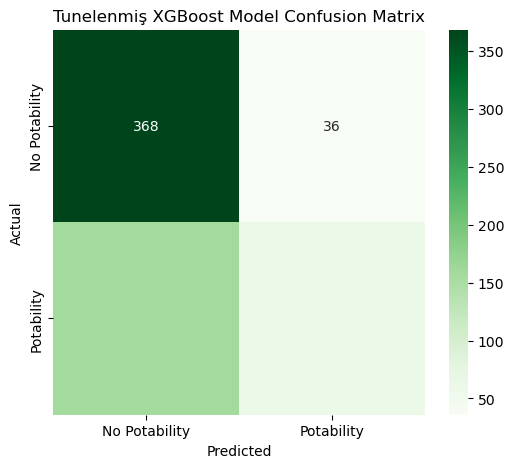

Tunelenmiş XGBoost Model Classification Report
              precision    recall  f1-score   support

         0.0       0.70      0.91      0.79       404
         1.0       0.63      0.28      0.39       219

    accuracy                           0.69       623
   macro avg       0.66      0.59      0.59       623
weighted avg       0.67      0.69      0.65       623



In [105]:
from sklearn.model_selection import GridSearchCV

# Parametre ızgarası
param_grid_xgb = {
    'n_estimators': [50, 100, 150],       # Ağaç sayısı
    'max_depth': [3, 5, 10],               # Ağaç derinliği
    'learning_rate': [0.01, 0.1, 0.2],     # Öğrenme oranı
    'subsample': [0.8, 1.0],               # Veri alt kümesi
    'colsample_bytree': [0.8, 1.0]         # Özellik alt kümesi
}


model_xgb_tune = xgb.XGBClassifier(random_state=42, use_label_encoder=False)


grid_search_xgb = GridSearchCV(estimator=model_xgb_tune, param_grid=param_grid_xgb, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')


grid_search_xgb.fit(X_train, y_train)


print(f"En İyi Tunelenmiş Parametreler: {grid_search_xgb.best_params_}")


best_model_xgb = grid_search_xgb.best_estimator_
y_pred_xgb_best = best_model_xgb.predict(X_test)


test_accuracy_xgb_best = accuracy_score(y_test, y_pred_xgb_best)
print(f"Test Doğruluğu (Tunelenmiş XGBoost): {test_accuracy_xgb_best}")


train_accuracy_xgb = model_xgb.score(X_train, y_train)
train_error_xgb = 1 - train_accuracy_xgb
test_error_xgb = 1 - test_accuracy_xgb

print(f"Train Doğruluğu (XGBoost): {train_accuracy_xgb}")
print(f"Test Hata Oranı (XGBoost): {test_error_xgb}")
print(f"Train Hata Oranı (XGBoost): {train_error_xgb}")



conf_matrix_xgb_best = confusion_matrix(y_test, y_pred_xgb_best)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_xgb_best, annot=True, fmt="d", cmap="Greens", xticklabels=['No Potability', 'Potability'], yticklabels=['No Potability', 'Potability'])
plt.title("Tunelenmiş XGBoost Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


print("Tunelenmiş XGBoost Model Classification Report")
print(classification_report(y_test, y_pred_xgb_best))


Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
En İyi Tunelenmiş Parametreler: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 1.0}
Test Doğruluğu (Tunelenmiş XGBoost): 0.6773675762439807
Train Doğruluğu (Tunelenmiş XGBoost): 0.7886701486540779
Test Hata Oranı (Tunelenmiş XGBoost): 0.3226324237560193
Train Hata Oranı (Tunelenmiş XGBoost): 0.21132985134592208


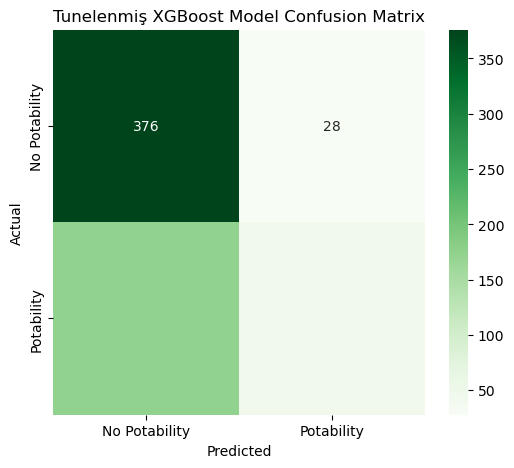

Tunelenmiş XGBoost Model Classification Report
              precision    recall  f1-score   support

         0.0       0.68      0.93      0.79       404
         1.0       0.62      0.21      0.31       219

    accuracy                           0.68       623
   macro avg       0.65      0.57      0.55       623
weighted avg       0.66      0.68      0.62       623



In [109]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


param_grid_xgb_tuned = {
    'n_estimators': [50, 100, 150],          # Ağaç sayısını sınırlayalım
    'max_depth': [3, 5, 7],                   # Derinliği daha küçük tutalım (overfitting'i azaltmak için)
    'learning_rate': [0.01, 0.05, 0.1],      # Öğrenme oranını daha düşük tutalım
    'subsample': [0.6, 0.8, 1.0],             # Verinin alt kümesini kullanalım
    'colsample_bytree': [0.6, 0.8, 1.0],     # Özellik alt kümesi oranını kısıtalım
    'gamma': [0, 0.1, 0.2],                   # Ekstra sınıflandırma karmaşıklığı ekler, overfitting'i azaltmaya yardımcı olabilir
    'min_child_weight': [1, 3, 5]             # Daha yüksek min_child_weight, daha fazla generalizasyon sağlar
}


model_xgb_tune = xgb.XGBClassifier(random_state=42, use_label_encoder=False)


grid_search_xgb_tune = GridSearchCV(estimator=model_xgb_tune, param_grid=param_grid_xgb_tuned, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')


grid_search_xgb_tune.fit(X_train, y_train)


print(f"En İyi Tunelenmiş Parametreler: {grid_search_xgb_tune.best_params_}")


best_model_xgb_tune = grid_search_xgb_tune.best_estimator_
y_pred_xgb_tune = best_model_xgb_tune.predict(X_test)


test_accuracy_xgb_tune = accuracy_score(y_test, y_pred_xgb_tune)
print(f"Test Doğruluğu (Tunelenmiş XGBoost): {test_accuracy_xgb_tune}")


train_accuracy_xgb_tune = best_model_xgb_tune.score(X_train, y_train)
train_error_xgb_tune = 1 - train_accuracy_xgb_tune
test_error_xgb_tune = 1 - test_accuracy_xgb_tune

print(f"Train Doğruluğu (Tunelenmiş XGBoost): {train_accuracy_xgb_tune}")
print(f"Test Hata Oranı (Tunelenmiş XGBoost): {test_error_xgb_tune}")
print(f"Train Hata Oranı (Tunelenmiş XGBoost): {train_error_xgb_tune}")


conf_matrix_xgb_tune = confusion_matrix(y_test, y_pred_xgb_tune)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_xgb_tune, annot=True, fmt="d", cmap="Greens", xticklabels=['No Potability', 'Potability'], yticklabels=['No Potability', 'Potability'])
plt.title("Tunelenmiş XGBoost Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


print("Tunelenmiş XGBoost Model Classification Report")
print(classification_report(y_test, y_pred_xgb_tune))


- Xboost islem görmüs veri setinde random foreste göre tuning isleminden sonra daha iyi bir sonuç verdi overfitin kısmen önüne geçmiş olduk 

### SVM

Fitting 5 folds for each of 12 candidates, totalling 60 fits
En İyi Tunelenmiş Parametreler: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Train Doğruluğu (Tunelenmiş SVM): 0.7235837685817598
Test Doğruluğu (Tunelenmiş SVM): 0.6982343499197432
Train Hata Oranı (Tunelenmiş SVM): 0.27641623141824023
Test Hata Oranı (Tunelenmiş SVM): 0.3017656500802568


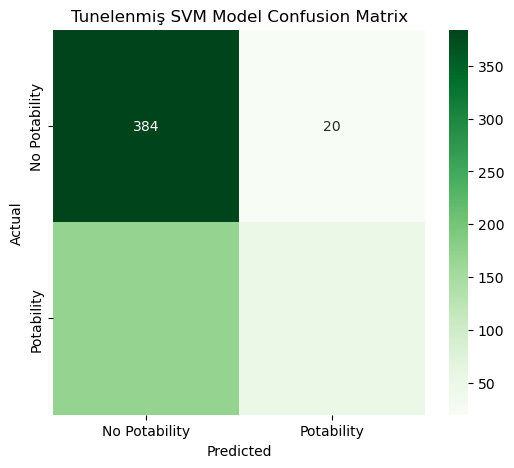

Tunelenmiş SVM Model Classification Report
              precision    recall  f1-score   support

         0.0       0.70      0.95      0.80       404
         1.0       0.72      0.23      0.35       219

    accuracy                           0.70       623
   macro avg       0.71      0.59      0.58       623
weighted avg       0.70      0.70      0.64       623



In [117]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


param_grid_svm = {
    'C': [0.1, 1, 10],               # C parametresi (penaltı)
    'kernel': ['linear', 'rbf'],     # Kernel fonksiyonları (Doğrusal ve RBF)
    'gamma': ['scale', 'auto']       # Kernel parametresi
}


model_svm = SVC(random_state=42)


grid_search_svm = GridSearchCV(estimator=model_svm, param_grid=param_grid_svm, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')


grid_search_svm.fit(X_train_scaled, y_train)


print(f"En İyi Tunelenmiş Parametreler: {grid_search_svm.best_params_}")


best_model_svm = grid_search_svm.best_estimator_
y_pred_svm = best_model_svm.predict(X_test_scaled)


train_accuracy_svm = best_model_svm.score(X_train_scaled, y_train)
test_accuracy_svm = accuracy_score(y_test, y_pred_svm)


train_error_svm = 1 - train_accuracy_svm
test_error_svm = 1 - test_accuracy_svm


print(f"Train Doğruluğu (Tunelenmiş SVM): {train_accuracy_svm}")
print(f"Test Doğruluğu (Tunelenmiş SVM): {test_accuracy_svm}")
print(f"Train Hata Oranı (Tunelenmiş SVM): {train_error_svm}")
print(f"Test Hata Oranı (Tunelenmiş SVM): {test_error_svm}")


conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Greens", xticklabels=['No Potability', 'Potability'], yticklabels=['No Potability', 'Potability'])
plt.title("Tunelenmiş SVM Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


print("Tunelenmiş SVM Model Classification Report")
print(classification_report(y_test, y_pred_svm))
